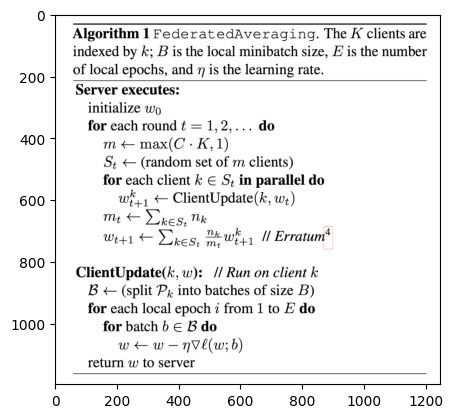

In [ ]:
# show the algorithm
import matplotlib.pyplot as plt

image_path = '/content/Screenshot 2023-11-28 at 6.27.29 PM.png'

X = plt.imread(image_path)
plt.imshow(X)

## Purpose

Compare the communication rounds required by both  FedSGD optimization, which processes a single batch gradient per communication round, and FedAvg optimization to demonsrate FedAvg's performance in addressing the high communication cost issue in federated learning setting.

### Hypeparameters:
FedSGD:
* SGD_NUM_EPOCHS = 1
* SGD_BATCH_SIZE = float('inf') # treat the local dataset as a single minibatch, meaning all the data held by these clients

FedAvg:
* AVG_NUM_EPOCHS = 5
* AVG_BATCH_SIZE = 50 # same parameter used in the paper

Vanilla_SGD:
* VANILLA_SGD_BATCH_SIZE = 100 # same parameter used in the paper


### Implementation
We will train the model using normal SGD optimization (non-FL) to set the baseline performance. Then we will compared how many rounds needed by FedSGD and FegAvg to reach the same level of performance.

In [ ]:
# define server and client classes

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Both Server and Client use Torch-type model

class Server:
    # client_fraction we use 1 as default
    def __init__(self, initial_weights, num_clients, device='cpu', client_fraction=1):
        self.global_weights = initial_weights  # PyTorch state_dict
        self.client_fraction = client_fraction
        self.num_clients = num_clients # assuming each client has a unique index
        self.device = device  # Add device attribute

    def select_clients(self):
        if self.client_fraction == 1:
            return list(range(self.num_clients))
        m = max(int(self.client_fraction * self.num_clients), 1)
        selected_clients = np.random.choice(self.num_clients, m, replace=False)
        return selected_clients

    def aggregate_updates(self, client_updates, client_data_counts):
      total_data_count = sum(client_data_counts)
      # Initialize a new state_dict for the aggregated weights, ensuring it's on the correct device and data type
      aggregated_weights = {key: torch.zeros_like(val, device=self.device, dtype=torch.float) for key, val in self.global_weights.items()}

      for client_weights, data_count in zip(client_updates, client_data_counts):
          client_weights = {k: v.to(self.device, dtype=torch.float) for k, v in client_weights.items()}  # Ensure client weights are on the same device and data type
          for key in self.global_weights.keys():
              # Aggregate the weights for each layer
              aggregated_weights[key] += client_weights[key] * (data_count / total_data_count)

      self.global_weights = aggregated_weights


    def send_global_weights(self):
        return self.global_weights



In [ ]:
class Client:
    # data is a list of (x, y) pairs
    # initial_weights is a numpy array, could be a pretained language model weights
    def __init__(self, data_loader, model, epochs, learning_rate, device='cpu'):
        self.data_loader = data_loader  # DataLoader object containing the client's data
        self.model = model  # PyTorch model
        self.epochs = epochs
        # We are comparing FedAvg with conventional FedSGD, so we use sgd as the optimizer
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        # Change to CrossEntropyLoss for multi-class classification
        self.criterion = nn.CrossEntropyLoss()
        self.device = device

    def train(self):
      self.model.train()  # Set the model to training mode
      for epoch in range(self.epochs):
          batch_num = 0  # Initialize batch counter
          for batch in self.data_loader:
              features, lengths, labels = [x.to(self.device) for x in batch]
              self.optimizer.zero_grad()
              outputs = self.model(features, lengths)
              loss = self.criterion(outputs, labels)
              loss.backward()
              self.optimizer.step()

              # Increment the batch counter and print the loss
              batch_num += 1
              print(f'Epoch: {epoch}, Batch: {batch_num}   Loss: {loss.item()}')
      return self.model.state_dict()  # Return the updated model weights

    # Update the local model with the global model
    def update_local_model(self, global_weights):
        self.model.load_state_dict(global_weights)

    # for weighted avrage use
    def get_data_count(self):
        return len(self.data_loader.dataset)

### For simulaton purpose, we create a sentiment analysis model

In [ ]:
# Hyperparameters

# To emulate the experiment's hyperparameters as described in the paper,
# and considering that we cannot create 100 clients due to hardware and dataset limitations, while also using C=0.1 of all clients,
# we created only 10 clients using a yelp review dataset but sorted by rating stars with different sizes to simulate a non-IID and unbalanced situation.

NUM_CLIENTS = 10
AVG_NUM_EPOCHS = 5
AVG_BATCH_SIZE = 50 # will be used to create the dataloader for training and testing data later
SGD_NUM_EPOCHS = 1
SGD_BATCH_SIZE = float('inf') # no minibatch in sgd setting
VANILLA_SGD_BATCH_SIZE = 100

DEVICE = 'cuda:0'
LEARNING_RATE = 0.01


### Create model

In [ ]:
import torch
import torch.nn as nn

# five classes in the yelp review dataset: rating starts from 1 to 5
class SentimentAnalysisModel(nn.Module):
    def __init__(self, vocab_size=30000, embedding_dim=100, hidden_dim=256, output_dim=5, n_layers=2, bidirectional=True, dropout=0.5):
        super().__init__()

        # Embedding layer
        # we could use a pre-trained embedding matrix here. But it's not used in this case.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)

        # Fully connected layers with Batch Normalization and ReLU
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # 2 for bidirectional
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        #  the output layer for multi-class classification
        self.fc3 = nn.Linear(32, output_dim)  # output_dim should be the number of classes

        # ReLU and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        # print("text device:", text.device)
        # print("text_lengths device:", text_lengths.device)
        # Embedding
        embedded = self.embedding(text)

        # Pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Move text_lengths back to GPU if the device is CUDA
        # if DEVICE == "cuda:0":
        #     text_lengths = text_lengths.to(DEVICE)

        # Concat the final forward and backward hidden layers
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)

        # Fully connected layers
        x = self.fc1(hidden)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x # return logits instead of softmax as we are using crossentropy


In [ ]:
# Create the global model
GLOBAL_INITIAL_MODEL = SentimentAnalysisModel()

In [ ]:
total_params = sum(p.numel() for p in GLOBAL_INITIAL_MODEL.parameters())

In [ ]:
total_params

5345413

### Prepare datasets

I will use the Yelp review dataset, which contains the content of reviews and the corresponding stars for each review. To mimic the non-IID and unbalanced data input situation described in the paper, I will first sort all reviews by their star ratings and then divide them into 10 'unbalanced' shards for the 10 client nodes. There are a total of 10,000 reviews, but they will not have an equal number of data examples.

In [ ]:
import spacy
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

In [ ]:
# load the yelp review csv file
df = pd.read_csv('yelp.csv')
df = df [['stars','text']]

In [ ]:
# load a english langiage model provided by spacy, for more nlp operations
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def preprocess_text(doc):
  # remove punctuation, white spaces, but include pure alphabets
  return [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space and token.is_alpha]

In [ ]:
# store the processed tokens in the dataframe

df['tokens'] = [preprocess_text(doc) for doc in nlp.pipe(df['text'], batch_size=500)]

In [ ]:
# To display the first 5 rows of the data frame
print(df.head(10))


   stars                                               text  \
0      5  My wife took me here on my birthday for breakf...   
1      5  I have no idea why some people give bad review...   
2      4  love the gyro plate. Rice is so good and I als...   
3      5  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...   
4      5  General Manager Scott Petello is a good egg!!!...   
5      4  Quiessence is, simply put, beautiful.  Full wi...   
6      5  Drop what you're doing and drive here. After I...   
7      4  Luckily, I didn't have to travel far to make m...   
8      4  Definitely come for Happy hour! Prices are ama...   
9      5  Nobuo shows his unique talents with everything...   

                                              tokens  
0  [my, wife, take, i, here, on, my, birthday, fo...  
1  [i, have, no, idea, why, some, people, give, b...  
2  [love, the, gyro, plate, rice, be, so, good, a...  
3  [rosie, dakota, and, i, love, chaparral, dog, ...  
4  [general, manager, scott, pe

In [ ]:
# Build the vocab
words = set()
for tokens in df['tokens']:
    words.update(tokens)
word_to_idx = {word: i + 2 for i, word in enumerate(sorted(words))}  # index 1 is reserved for padding
word_to_idx['<unk>'] = 1

In [ ]:
# encode tokens into integers
df['encoded_tokens'] = df['tokens'].apply(lambda x: [word_to_idx.get(word, 1) for word in x])

In [ ]:
print(df.head(10))

   stars                                               text  \
0      5  My wife took me here on my birthday for breakf...   
1      5  I have no idea why some people give bad review...   
2      4  love the gyro plate. Rice is so good and I als...   
3      5  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...   
4      5  General Manager Scott Petello is a good egg!!!...   
5      4  Quiessence is, simply put, beautiful.  Full wi...   
6      5  Drop what you're doing and drive here. After I...   
7      4  Luckily, I didn't have to travel far to make m...   
8      4  Definitely come for Happy hour! Prices are ama...   
9      5  Nobuo shows his unique talents with everything...   

                                              tokens  \
0  [my, wife, take, i, here, on, my, birthday, fo...   
1  [i, have, no, idea, why, some, people, give, b...   
2  [love, the, gyro, plate, rice, be, so, good, a...   
3  [rosie, dakota, and, i, love, chaparral, dog, ...   
4  [general, manager, scot

In [ ]:
# Custom Dataset Class
class YelpReviewsDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])


    # suggested by ChatGPT:
    def collate_fn(batch):
      batch_sequences = [item[0] for item in batch]
      batch_labels = [item[1] for item in batch]

      # Compute lengths before padding
      lengths = torch.tensor([len(seq) for seq in batch_sequences])

      # Pad sequences
      batch_sequences_padded = pad_sequence(batch_sequences, batch_first=True)

      return batch_sequences_padded, lengths, torch.tensor(batch_labels)


In [ ]:
labels = df['stars'].values - 1

print(labels)

[4 4 3 ... 3 1 4]


In [ ]:
# Prepare the dataset for vanilla-SGD model for baseline performance test


X_train, X_test, y_train, y_test = train_test_split(df['encoded_tokens'].tolist(), labels, test_size=0.2, random_state=42)

vanilla_sgd_train_dataset = YelpReviewsDataset(X_train, y_train)
vanilla_sgd_test_dataset = YelpReviewsDataset(X_test, y_test)

vanilla_sgd_train_loader = DataLoader(vanilla_sgd_train_dataset, batch_size=VANILLA_SGD_BATCH_SIZE, shuffle=True, collate_fn=YelpReviewsDataset.collate_fn)
vanilla_sgd_test_loader = DataLoader(vanilla_sgd_test_dataset, batch_size=VANILLA_SGD_BATCH_SIZE, collate_fn=YelpReviewsDataset.collate_fn)



In [ ]:
vanilla_sgd_train_loader

In [ ]:
# Prepare the dataset for the 10 federated clients

# sort the data frame based on review ratings, in order to create non-IID datasets
# in-place sorting to save memory

df.sort_values(by='stars', ascending=True, inplace=True)

In [ ]:
print(df.head(10))

      stars                                               text  \
3456      1  My husband and I went there for our first time...   
1747      1  This dog park gets one star.Why?Because the la...   
5543      1  This review is for the bar only.\nI had a date...   
4934      1  I'd have to disagree with the person who said ...   
7037      1  3 months, 22 emails, 10 plus calls and (I thin...   
9767      1  We came there on November 5, 2011 and the serv...   
5541      1  I went here while on vacation visiting my frie...   
707       1  not clean, worst gel manicure ever and ruined ...   
7035      1  Totally excited to try this place out, my gran...   
1735      1  Great at first, then the bartender ignored me ...   

                                                 tokens  \
3456  [my, husband, and, i, go, there, for, our, fir...   
1747  [this, dog, park, get, one, star, the, last, t...   
5543  [this, review, be, for, the, bar, only, i, hav...   
4934  [i, have, to, disagree, with, t

In [ ]:

num_shards = 10
shards = []

proportions = [0.05, 0.1, 0.01, 0.1, 0.03, 0.1, 0.1, 0.19, 0.17, 0.15]

In [ ]:
# Calculate the cumulative sum of proportions to get indices for slicing
cumulative_proportions = np.cumsum(proportions)

print(cumulative_proportions)

[0.05 0.15 0.16 0.26 0.29 0.39 0.49 0.68 0.85 1.  ]


In [ ]:
# Calculate the indices at which to slice the DataFrame
indices = (cumulative_proportions * len(df)).astype(int)

print(indices)


[  500  1500  1600  2600  2900  3900  4900  6799  8500 10000]


In [ ]:
start_idx = 0
for end_idx in indices:
    # Slice the DataFrame to create a shard
    shard = df[start_idx:end_idx]
    shards.append(shard)
    start_idx = end_idx

In [ ]:
shard_sizes = []
for shard in shards:
    shard_sizes.append(len(shard))

print(shard_sizes)

[500, 1000, 100, 1000, 300, 1000, 1000, 1899, 1701, 1500]


In [ ]:
print(shards[9].head(10))

      stars                                               text  \
1456      5  What happened to this place?  The food was goo...   
1477      5  I' m psycho for this place.  The sell cupcakes...   
1455      5  I've been going to Lake Pleasant Dentistry for...   
1449      5  Hole-in-the-Rock is a cave-like natural rock f...   
1447      5  Awesome, awesome, awesome....everything was fa...   
1446      5  I can now thank the Humane Society for not onl...   
1445      5  So my friend and I stumbled upon this place on...   
1444      5  Dude...a happy hour that is TRULY happy!!!  \n...   
1443      5  Awesome food anyone??? Go check out Modern Ste...   
1441      5  Mister Softee is an all-star, he showed up on ...   

                                                 tokens  \
1456  [what, happen, to, this, place, the, food, be,...   
1477  [i, m, psycho, for, this, place, the, sell, cu...   
1455  [i, be, go, to, lake, pleasant, dentistry, for...   
1449  [hole, in, the, rock, be, a, ca

In [ ]:
# Prepare the datasets for FedSGD training, where the local data at a client node is a single batch
# Prepare the datasets for FedAvg training, where we have to use minibatch size AVG_BATCH_SIZE

# Dictionaries to store DataLoaders for each shard
fedsgd_train_loaders = []
fedsgd_val_loaders = []
fedavg_train_loaders = []
fedavg_val_loaders = []

for i, shard in enumerate(shards):
    # Adjust labels to range from 0 to 4 using .loc
    shard.loc[:, 'stars'] = shard['stars'] - 1

    # Split the data for both FedSGD and FedAvg
    X_train_sgd, X_val_sgd, y_train_sgd, y_val_sgd = train_test_split(shard['encoded_tokens'].tolist(), shard['stars'].tolist(), test_size=0.2, random_state=42)
    X_train_avg, X_val_avg, y_train_avg, y_val_avg = train_test_split(shard['encoded_tokens'].tolist(), shard['stars'].tolist(), test_size=0.2, random_state=42)

    train_dataset_sgd = YelpReviewsDataset(X_train_sgd, y_train_sgd)
    val_dataset_sgd = YelpReviewsDataset(X_val_sgd, y_val_sgd)

    train_dataset_avg = YelpReviewsDataset(X_train_avg, y_train_avg)
    val_dataset_avg = YelpReviewsDataset(X_val_avg, y_val_avg)

    fedsgd_train_loader = DataLoader(train_dataset_sgd, batch_size=len(train_dataset_sgd), shuffle=True, collate_fn=YelpReviewsDataset.collate_fn) # to handle variable-length
    fedsgd_val_loader = DataLoader(val_dataset_sgd, batch_size=len(val_dataset_sgd), collate_fn=YelpReviewsDataset.collate_fn)
    fedsgd_train_loaders.append(fedsgd_train_loader)
    fedsgd_val_loaders.append(fedsgd_val_loader)

    fedavg_train_loader = DataLoader(train_dataset_avg, batch_size=AVG_BATCH_SIZE, shuffle=True, collate_fn=YelpReviewsDataset.collate_fn)
    fedavg_val_loader = DataLoader(val_dataset_avg, batch_size=AVG_BATCH_SIZE, collate_fn=YelpReviewsDataset.collate_fn)
    fedavg_train_loaders.append(fedavg_train_loader)
    fedavg_val_loaders.append(fedavg_val_loader)


<ipython-input-108-2f28d3cc2625>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shard.loc[:, 'stars'] = shard['stars'] - 1


In [ ]:
len(fedavg_train_loaders)

10

### Train the model using vanilla sgd to have the baseline performance

In [ ]:
VANILLA_SGD_EPOCHS = 100
VANILLA_SGD_LR = 0.01


vanilla_sgd_model = SentimentAnalysisModel()
vanilla_sgd_model.to(DEVICE)

vanilla_sgd_optimizer = torch.optim.SGD(vanilla_sgd_model.parameters(), lr=VANILLA_SGD_LR)
vanilla_sgd_criterion = torch.nn.CrossEntropyLoss()

vanilla_sgd_train_loss_history = []
vanilla_sgd_val_loss_history = []

vanilla_sgd_train_acc_history = []
vanilla_sgd_val_acc_history = []


In [ ]:
total_train_batches = 0
total_val_batches = 0

for epoch in range(VANILLA_SGD_EPOCHS):
    # Training phase
    vanilla_sgd_model.train()
    train_loss, train_correct, train_batch_count = 0, 0, 0
    for inputs, lengths, labels in vanilla_sgd_train_loader:
        # if inputs.max() > max_index or inputs.min() < min_index:
        #   print(f"Found out-of-range index in inputs. Max allowed: {max_index}, Min allowed: {min_index}")
        #   print(f"Max in inputs: {inputs.max()}, Min in inputs: {inputs.min()}")
        #   break
        # inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        inputs, lengths, labels = inputs.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
        # lengths tensor does not need to be moved to CUDA for pack_padded_sequence
        # but should be on CUDA for other operations in the model
        # print("Inputs shape:", inputs.shape)
        # print("Lengths:", lengths)
        # print("Max length in batch:", lengths.max())
        # print("Min length in batch:", lengths.min())

        vanilla_sgd_optimizer.zero_grad()
        # Move lengths to CUDA for model operations other than pack_padded_sequence
        # outputs = vanilla_sgd_model(inputs, lengths.to(DEVICE))  # Move lengths to CUDA here
        outputs = vanilla_sgd_model(inputs, lengths)
        loss = vanilla_sgd_criterion(outputs, labels)
        loss.backward()
        vanilla_sgd_optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        train_batch_count += 1
        total_train_batches += 1

        # Print current training status after each batch
        print(f"Epoch {epoch+1}/{VANILLA_SGD_EPOCHS}, Batch {train_batch_count}/{len(vanilla_sgd_train_loader)}, Batch Loss: {loss.item():.4f}, Batch Acc: {(outputs.argmax(1) == labels).float().mean().item():.4f}")

    avg_train_loss = train_loss / len(vanilla_sgd_train_loader.dataset)
    train_accuracy = train_correct / len(vanilla_sgd_train_loader.dataset)
    vanilla_sgd_train_loss_history.append(avg_train_loss)
    vanilla_sgd_train_acc_history.append(train_accuracy)

    # Validation phase
    vanilla_sgd_model.eval()
    val_loss, val_correct, val_batch_count = 0, 0, 0
    with torch.no_grad():
        for inputs, lengths, labels in vanilla_sgd_test_loader:
            # if inputs.max() > max_index or inputs.min() < min_index:
            #   print(f"Found out-of-range index in inputs. Max allowed: {max_index}, Min allowed: {min_index}")
            #   print(f"Max in inputs: {inputs.max()}, Min in inputs: {inputs.min()}")
            #   break
            # inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            inputs, lengths, labels = inputs.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)

            # Move lengths to CUDA for model operations
            # outputs = vanilla_sgd_model(inputs, lengths.to(DEVICE))  # Move lengths to CUDA here
            outputs = vanilla_sgd_model(inputs, lengths)

            loss = vanilla_sgd_criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            val_batch_count += 1
            total_val_batches += 1

            # Print current val status after each batch
            print(f"Epoch {epoch+1}/{VANILLA_SGD_EPOCHS}, Batch {val_batch_count}/{len(vanilla_sgd_test_loader)}, Batch Loss: {loss.item():.4f}, Batch Acc: {(outputs.argmax(1) == labels).float().mean().item():.4f}")

    avg_val_loss = val_loss / len(vanilla_sgd_test_loader.dataset)
    val_accuracy = val_correct / len(vanilla_sgd_test_loader.dataset)
    vanilla_sgd_val_loss_history.append(avg_val_loss)
    vanilla_sgd_val_acc_history.append(val_accuracy)

    # Print epoch summary
    # print(f"Epoch {epoch+1}/{VANILLA_SGD_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


Streaming output truncated to the last 5000 lines.
Epoch 51/100, Batch 1/80, Batch Loss: 1.3931, Batch Acc: 0.4100
Epoch 51/100, Batch 2/80, Batch Loss: 1.3206, Batch Acc: 0.3500
Epoch 51/100, Batch 3/80, Batch Loss: 1.2721, Batch Acc: 0.4700
Epoch 51/100, Batch 4/80, Batch Loss: 1.3216, Batch Acc: 0.4500
Epoch 51/100, Batch 5/80, Batch Loss: 1.2527, Batch Acc: 0.3900
Epoch 51/100, Batch 6/80, Batch Loss: 1.3253, Batch Acc: 0.4000
Epoch 51/100, Batch 7/80, Batch Loss: 1.3228, Batch Acc: 0.4300
Epoch 51/100, Batch 8/80, Batch Loss: 1.2127, Batch Acc: 0.5000
Epoch 51/100, Batch 9/80, Batch Loss: 1.3025, Batch Acc: 0.4500
Epoch 51/100, Batch 10/80, Batch Loss: 1.2504, Batch Acc: 0.4700
Epoch 51/100, Batch 11/80, Batch Loss: 1.2545, Batch Acc: 0.4200
Epoch 51/100, Batch 12/80, Batch Loss: 1.2312, Batch Acc: 0.4700
Epoch 51/100, Batch 13/80, Batch Loss: 1.2312, Batch Acc: 0.4600
Epoch 51/100, Batch 14/80, Batch Loss: 1.2589, Batch Acc: 0.4100
Epoch 51/100, Batch 15/80, Batch Loss: 1.3354, B

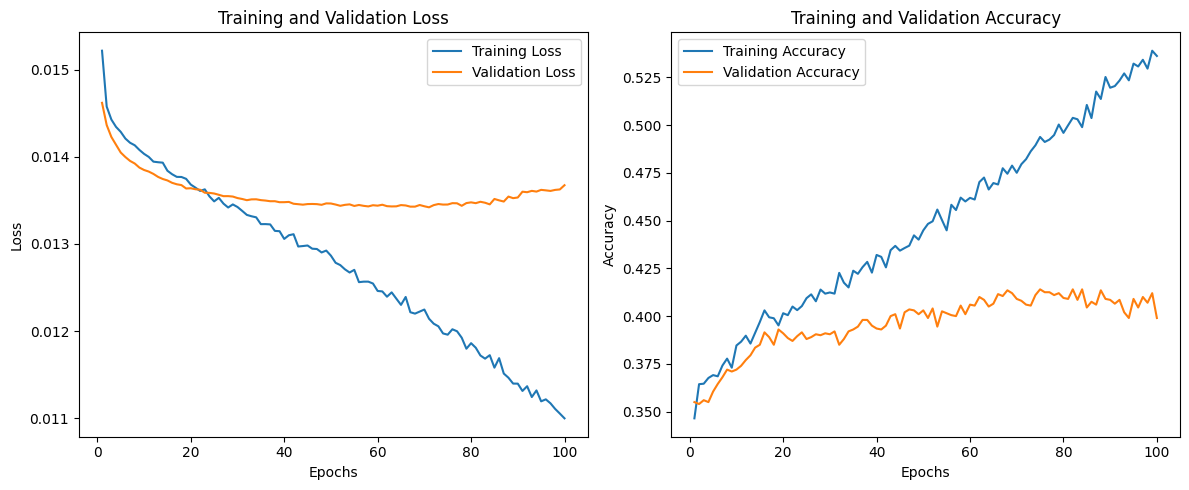

In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, VANILLA_SGD_EPOCHS + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, vanilla_sgd_train_loss_history, label='Training Loss')
plt.plot(epochs, vanilla_sgd_val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, vanilla_sgd_train_acc_history, label='Training Accuracy')
plt.plot(epochs, vanilla_sgd_val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print("Total train batchs: ", total_train_batches)
print("Total val batchs: ", total_val_batches)

Total train batchs:  8000
Total val batchs:  2000


#### We see clear overfitting from the result from vanilla sgd training and I think we should possibly do better by adding more training data. But as the training of the vanilla sgd model only serves the purpose of providing baseline performance for later FedSGD and FedAvg training, we'll just set the baseline perfromance to be 40%. (Not good performance, I know)

In [ ]:
# used for evaluating if the global model has met the threshold

# def evaluate_model(model, val_loader, device):
#     model.to(device)  # Move the model to the specified device
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             features, lengths, labels = [x.to(device) for x in batch]  # Move data to the same device
#             outputs = model(features, lengths)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     return correct / total


In [ ]:
def evaluate_model(model, val_loaders, device):
    model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode

    accuracy = []
    with torch.no_grad():
      for loader in val_loaders:
        correct = 0
        total = 0
        for batch in loader:
            features, lengths, labels = [x.to(device) for x in batch]  # Move data to the same device
            outputs = model(features, lengths)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy for each loader and append to list
        accuracy.append(correct / total)

    return sum(accuracy) / len(accuracy)

In [ ]:
import copy

In [ ]:
GLOBAL_INITIAL_MODEL = SentimentAnalysisModel()

### FedSGD Training

**Note: Due to limited computational power and time constraints, only FedAvg training is complete (see below). However, I plan to complete the experiment later, even after December 14th. If you are seeing this note, it simply means the FedSGD experiment is not complete. The reason I chose to first experiment with the FedAvg algorithm is not only because it's the algorithm described in the paper but also because theoretically, FedSGD would require more communication rounds (an order of magnitude) to meet the baseline performance demonstrated by the vanilla SGD model. Maybe wait until next month; my Colab Pro renews so that I will have more computational units.**


But the code below is still for reference.

In [ ]:
# create 10 clients

fedsgd_server = Server(initial_weights=GLOBAL_INITIAL_MODEL.state_dict(), num_clients=10, device=DEVICE)

fedsgd_clients = [
    Client(
        data_loader=loader,
        model=copy.deepcopy(GLOBAL_INITIAL_MODEL),
        epochs=SGD_NUM_EPOCHS, # which is only 1
        learning_rate=LEARNING_RATE,
        device = DEVICE
    ) for loader in fedsgd_train_loaders
]

sgd_global_model = copy.deepcopy(GLOBAL_INITIAL_MODEL)

In [ ]:
MAX_ROUNDS = 10000
ACCURACY_THRESHOLD = 0.4

In [ ]:
round_accuracies_sgd = []  # List to track accuracy for each round

round_sgd = 0
while round_sgd < MAX_ROUNDS:
    sgd_global_weights = fedsgd_server.send_global_weights()
    sgd_global_model.load_state_dict(sgd_global_weights)

    client_updates = []
    client_data_counts = []

    # Client updates
    idx = 1
    for client in fedsgd_clients:
        print(f"*******************************   Client {idx}, Round {round_sgd+1}  *****************************************")
        idx += 1
        client.update_local_model(sgd_global_weights)
        client.model.to(client.device)  # Ensure the model is on the correct device
        updated_weights = client.train()
        client_updates.append(updated_weights)
        client_data_counts.append(client.get_data_count())

    # Aggregate updates
    fedsgd_server.aggregate_updates(client_updates, client_data_counts)
    sgd_global_weights = fedsgd_server.send_global_weights()
    sgd_global_model.load_state_dict(sgd_global_weights)

    # Evaluation on the validation set
    accuracy = evaluate_model(sgd_global_model, fedsgd_val_loaders, DEVICE)
    round_accuracies_sgd.append(accuracy)  # Track accuracy
    print(f"Round {round_sgd + 1}: Accuracy = {accuracy}")

    round_sgd += 1
    if accuracy >= ACCURACY_THRESHOLD:
        print(f"Global model has met the accuracy threshold after {round_sgd} rounds")
        break
else:
    print(f"Reached the maximum number of rounds ({MAX_ROUNDS}) without meeting the threshold.")

### FedAvg Training

In [ ]:
fedavg_server = Server(initial_weights=GLOBAL_INITIAL_MODEL.state_dict(), num_clients=10, device=DEVICE)

fedavg_clients = [
    Client(
        data_loader=loader,
        model=copy.deepcopy(GLOBAL_INITIAL_MODEL),
        epochs=AVG_NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        device = DEVICE
    ) for loader in fedavg_train_loaders
]

global_model = copy.deepcopy(GLOBAL_INITIAL_MODEL)

In [ ]:
MAX_ROUNDS = 10000
ACCURACY_THRESHOLD = 0.4

In [ ]:
round_accuracies = []  # List to track accuracy for each round

round = 0
while round < MAX_ROUNDS:
    global_weights = fedavg_server.send_global_weights()
    global_model.load_state_dict(global_weights)

    client_updates = []
    client_data_counts = []

    # Client updates
    idx = 1
    for client in fedavg_clients:
        print(f"*******************************   Client {idx}, Round {round+1}  *****************************************")
        idx += 1
        client.update_local_model(global_weights)
        client.model.to(client.device)  # Ensure the model is on the correct device
        updated_weights = client.train()
        client_updates.append(updated_weights)
        client_data_counts.append(client.get_data_count())

    # Aggregate updates
    fedavg_server.aggregate_updates(client_updates, client_data_counts)
    global_weights = fedavg_server.send_global_weights()
    global_model.load_state_dict(global_weights)

    # Evaluation on the validation set
    accuracy = evaluate_model(global_model, fedavg_val_loaders, DEVICE)
    round_accuracies.append(accuracy)  # Track accuracy
    print(f"Round {round + 1}: Accuracy = {accuracy}")

    round += 1
    if accuracy >= ACCURACY_THRESHOLD:
        print(f"Global model has met the accuracy threshold after {round} rounds")
        break
else:
    print(f"Reached the maximum number of rounds ({MAX_ROUNDS}) without meeting the threshold.")


Streaming output truncated to the last 5000 lines.
Epoch: 1, Batch: 14   Loss: 0.061394281685352325
Epoch: 1, Batch: 15   Loss: 0.047262582927942276
Epoch: 1, Batch: 16   Loss: 0.06889284402132034
Epoch: 1, Batch: 17   Loss: 0.07724257558584213
Epoch: 1, Batch: 18   Loss: 0.057683635503053665
Epoch: 1, Batch: 19   Loss: 0.04885242506861687
Epoch: 1, Batch: 20   Loss: 0.0827370285987854
Epoch: 1, Batch: 21   Loss: 0.1024508848786354
Epoch: 1, Batch: 22   Loss: 0.08553283661603928
Epoch: 1, Batch: 23   Loss: 0.04830607399344444
Epoch: 1, Batch: 24   Loss: 0.056900687515735626
Epoch: 1, Batch: 25   Loss: 0.053267911076545715
Epoch: 1, Batch: 26   Loss: 0.05777556821703911
Epoch: 1, Batch: 27   Loss: 0.06579343229532242
Epoch: 1, Batch: 28   Loss: 0.05283389240503311
Epoch: 1, Batch: 29   Loss: 0.0499248281121254
Epoch: 1, Batch: 30   Loss: 0.06675950437784195
Epoch: 1, Batch: 31   Loss: 0.041150741279125214
Epoch: 2, Batch: 1   Loss: 0.049713391810655594
Epoch: 2, Batch: 2   Loss: 0.08223

KeyboardInterrupt: ignored

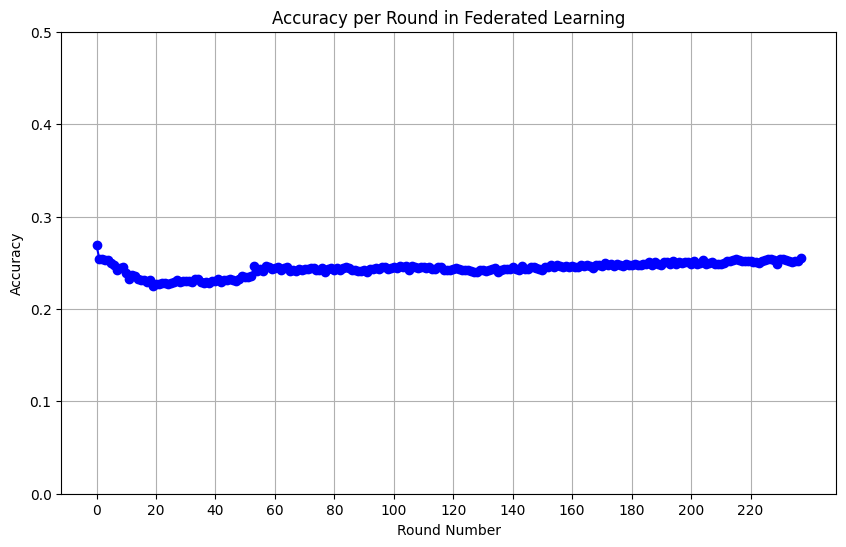

In [ ]:
import matplotlib.pyplot as plt

round_numbers = list(range(len(round_accuracies)))

# Generating tick labels for every 20 rounds
x_ticks = list(range(0, len(round_accuracies), 20))

# Plotting the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(round_numbers, round_accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy per Round in Federated Learning")
plt.xlabel("Round Number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(x_ticks)  # Set x-axis ticks
plt.ylim(0, 0.5)  # Assuming accuracy is a value between 0 and 0.5
plt.show()